Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from tempfile import TemporaryDirectory
import pandas as pd
import shutil
import random
import torch.nn.functional as F
from torch.utils.data.sampler import WeightedRandomSampler
import time
from datetime import datetime
import datetime as dt
import copy
from efficientnet_pytorch import EfficientNet
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

In [2]:
from data_setup import copy_images_to_folders, create_folders, remove_folders, split_data_for_class, split_data
from image_check import imshow
from model import CustomEfficientNetB0, CustomLoss, compute_class_weights, normalize_matrix, print_matrix, validate_model, train_model, plot_metrics, visualize_model
from uncertainty_metrics import calculate_risks, process_labels, calculate_and_append_risks, calculate_and_append_risks_by_class, calculate_softmax_uncertainties, calculate_top2_softmax_uncertainties, calculate_random_uncertainties, calculate_mc_dropout_uncertainties_by_sample, calculate_mc_dropout_uncertainties_by_class, calculate_variance_uncertainties, calculate_variational_ratio_uncertainties, calculate_entropy_uncertainties, calculate_predictive_entropy_uncertainties, calculate_mutual_information_uncertainties, smooth_calcs, calculate_aurc, plot_risk_coverage, process_uncertainties, calculate_variational_ratio_dropout_uncertainties, calculate_mutual_information_mc_dropout, select_desired_metrics

In [3]:
# use best algorithm for hardware
cudnn.benchmark = True

# interactive mode for graph plot
plt.ion()

# set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [4]:
# Constants
CSV_PATH = 'data/ISIC_2019_Training_GroundTruth.csv'
IMAGE_FOLDER = 'data/ISIC_2019_Resized'
SORTED_FOLDER = 'data/ISIC_Sorted'
SUBSET_FOLDER = 'data/data_subset'
SAMPLE_LIMIT = 100  # None or a number up to 12875
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2
SET_BATCH_SIZE = 64

#sample numbers by class copied here for reference
#MEL	NV	    BCC	    AK	 BKL	DF	VASC  SCC	UNK
#4522	12875	3323	867	 2624	239	253	  628	0

In [5]:
# Validation for ratios
if TRAIN_RATIO + VAL_RATIO + TEST_RATIO != 1:
    print("Invalid data ratios")
else:
    print("Data ratios are valid")

    # Perform operations
    copy_images_to_folders(CSV_PATH, IMAGE_FOLDER, SORTED_FOLDER)
    print("images split into classes")
    
    remove_folders(os.path.join(SUBSET_FOLDER, 'train'), os.path.join(SUBSET_FOLDER, 'val'), os.path.join(SUBSET_FOLDER, 'test'))
    
    split_data(SORTED_FOLDER, os.path.join(SUBSET_FOLDER, 'train'), os.path.join(SUBSET_FOLDER, 'val'), os.path.join(SUBSET_FOLDER, 'test'), train_ratio=TRAIN_RATIO, val_ratio=VAL_RATIO, test_ratio=TEST_RATIO, sample_limit=SAMPLE_LIMIT, seed=42)
    print("data split into train, validation and test sets for each class")
    
    # Remove unknown folder as there are no samples
    remove_folders(os.path.join(SUBSET_FOLDER, 'train', 'UNK'), os.path.join(SUBSET_FOLDER, 'val', 'UNK'), os.path.join(SUBSET_FOLDER, 'test', 'UNK'))
    print("UNK folders removed")

Data ratios are valid
images split into classes
data split into train, validation and test sets for each class
UNK folders removed


In [6]:
#transform data
data_transforms = {
'train': transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=360),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), shear=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'val': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'test': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
}

In [7]:
# create datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(SUBSET_FOLDER, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=SET_BATCH_SIZE, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# Adjusted way to obtain class names
class_names = image_datasets['train'].classes
num_classes = len(class_names)
print(f"file: ", class_names)

file:  ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


show sample images

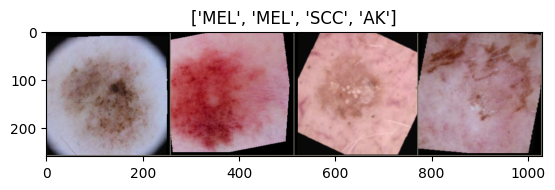

In [8]:
# Specify the number of images to display
num_images = 4

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Select a subset of images
inputs_subset = inputs[:num_images]
classes_subset = classes[:num_images]

# Make a grid from the subset
out = torchvision.utils.make_grid(inputs_subset)

imshow(out, title=[class_names[x] for x in classes_subset])

In [9]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

In [10]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_epoch = 1

# Initialize the custom model with dropout
model_ft = CustomEfficientNetB0(num_classes=num_classes, dropout_prob=0.4)

# Move the model to the specified device (e.g., GPU or CPU)
model_ft = model_ft.to(device)

# Define the loss function (cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# Use the Adam optimizer for training
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Define a learning rate scheduler to decay the learning rate
# by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Loaded pretrained weights for efficientnet-b0


In [11]:
# Convert targets to tensor and move to device
targets_tensor = torch.tensor(image_datasets['train'].targets).to(device)

# Compute class weights
class_weights = compute_class_weights(targets_tensor, len(image_datasets['train'].classes))

# Print class weights
print("Class Weights:", class_weights)

Class Weights: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [12]:
# Define the class weights matrices and move to device
equal_class_weights_matrix = torch.tensor([
    [0, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 0, 1, 1, 1, 1, 1],
    [1, 1, 1, 0, 1, 1, 1, 1],
    [1, 1, 1, 1, 0, 1, 1, 1],
    [1, 1, 1, 1, 1, 0, 1, 1],
    [1, 1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 0]
], dtype=torch.float).to(device)

custom_class_weights_matrix = torch.tensor([
    [0,  1,  20,  20,  10, 20,  10, 1],
    [1,  0,  30,  30,  10, 30,  10, 1],
    [10, 10, 0,   1,   10, 1,   10, 10],
    [10, 10, 1,   0,   10, 1,   10, 10],
    [10, 10, 150, 150, 0,  150, 1,  10],
    [10, 10, 1,   1,   10, 0,   10, 10],
    [10, 10, 150, 150, 1,  150, 0,  10],
    [1,  1,  20,  20,  10, 20,  10, 0]
], dtype=torch.float).to(device)

equal_class_weights_matrix = normalize_matrix(equal_class_weights_matrix)
custom_class_weights_matrix = normalize_matrix(custom_class_weights_matrix)

# Print the normalized matrices
print_matrix("Equal Cost Matrix", equal_class_weights_matrix)
print_matrix("Custom Cost Matrix", custom_class_weights_matrix)

Equal Cost Matrix:
tensor([[0.0000, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429],
        [0.1429, 0.0000, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429],
        [0.1429, 0.1429, 0.0000, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429],
        [0.1429, 0.1429, 0.1429, 0.0000, 0.1429, 0.1429, 0.1429, 0.1429],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.0000, 0.1429, 0.1429, 0.1429],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000, 0.1429, 0.1429],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000, 0.1429],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000]],
       device='cuda:0')
Custom Cost Matrix:
tensor([[0.0000, 0.0122, 0.2439, 0.2439, 0.1220, 0.2439, 0.1220, 0.0122],
        [0.0089, 0.0000, 0.2679, 0.2679, 0.0893, 0.2679, 0.0893, 0.0089],
        [0.1923, 0.1923, 0.0000, 0.0192, 0.1923, 0.0192, 0.1923, 0.1923],
        [0.1923, 0.1923, 0.0192, 0.0000, 0.1923, 0.0192, 0.1923, 0.1923],
        [0.0208, 0.0208, 0.3119, 0.3119, 0.0000,

In [15]:
# Balance the custom class weights matrix using the calculated class weights
balanced_class_weights_matrix = equal_class_weights_matrix * torch.tensor(class_weights, dtype=torch.float).unsqueeze(0).to(device) * 7

print_matrix("Balanced Class Weights Matrix", balanced_class_weights_matrix)

Balanced Class Weights Matrix:
tensor([[0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 0.]], device='cuda:0')


In [18]:
# Define the loss function using the custom loss
criterion = CustomLoss(balanced_class_weights_matrix).to(device)

In [19]:
model_ft = model_ft.to(device)

In [20]:
train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, device, train_losses, train_accuracies, val_losses, val_accuracies, best_epoch, num_epochs=2, num_val_mc_samples=1, loss_weight=1, acc_weight=0, num_classes=num_classes, save_dir="test", resume_training=False)

Epoch 1/2 - 2024-03-21 04:07:42
----------
Train Loss: 0.1679, Train Acc: 0.3438
Val Loss: 0.1690, Val Acc: 0.3375

Epoch 2/2 - 2024-03-21 04:08:02
----------
Train Loss: 0.0999, Train Acc: 0.5604
Val Loss: 0.1786, Val Acc: 0.3438

Best combined metric: -0.1690
Loss associated with the best combined metric: 0.1690
Accuracy associated with the best combined metric: 0.3375
Epoch associated with the best model: 1



In [21]:
# Load the checkpoint
checkpoint = torch.load('test/checkpoint.pth.tar')

# Load model state_dict
model_ft.load_state_dict(checkpoint['model_state_dict'])

# Load optimizer state_dict
optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])

# Load scheduler state_dict
exp_lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# Retrieve other variables
best_combined_metric = checkpoint['best_combined_metric']
best_val_loss = checkpoint['best_val_loss']
best_val_acc = checkpoint['best_val_acc']
best_epoch = checkpoint['best_epoch']
train_losses = checkpoint['train_losses']
train_accuracies = checkpoint['train_accuracies']
val_losses = checkpoint['val_losses']
val_accuracies = checkpoint['val_accuracies']

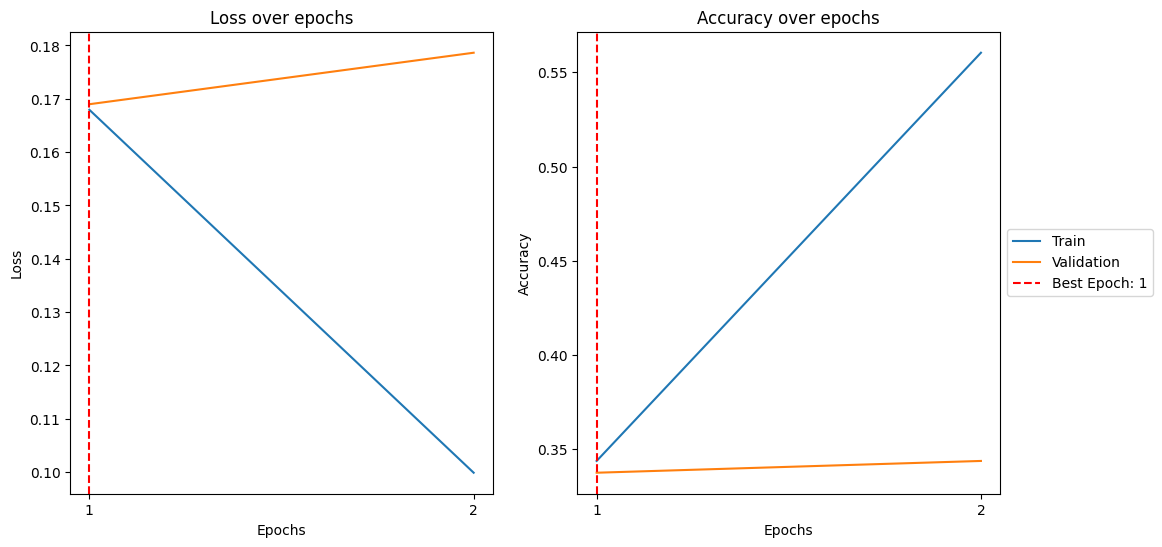

In [22]:
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, best_epoch)

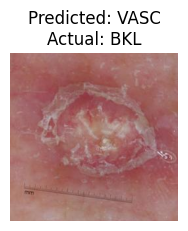

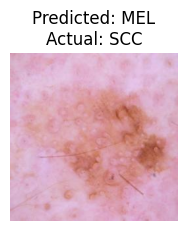

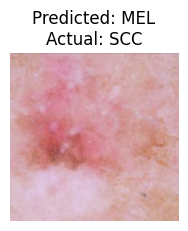

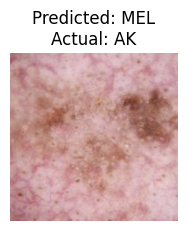

In [23]:
visualize_model(model_ft, dataloaders['val'], device, class_names, num_images=4)

In [24]:
# Lists to store results
risks_list = []
labels_list = []

risks_list_by_class = [[] for _ in range(len(class_names))]
labels_list_by_class = [[] for _ in range(len(class_names))]

uncertainty_functions = [
    (calculate_softmax_uncertainties, "Softmax Response"),
    (calculate_top2_softmax_uncertainties, "Top2 Softmax Difference"),
    (calculate_random_uncertainties, "Random Uncertainties"),
    (calculate_mc_dropout_uncertainties_by_sample, "MCD By Sample", {"num_samples": 1}),
    (calculate_mc_dropout_uncertainties_by_class, "MCD By Class", {"num_samples": 1}),
    (calculate_variance_uncertainties, "Variance"),
    (calculate_variational_ratio_uncertainties, "Variational Ratio"),
    (calculate_variational_ratio_dropout_uncertainties, "Variational Ratio with Dropout", {"num_samples": 1}),
    (calculate_entropy_uncertainties, "Entropy"),
    (calculate_predictive_entropy_uncertainties, "Predictive Entropy", {"num_samples": 1}),
    (calculate_mutual_information_uncertainties, "Mutual Information"),
    (calculate_mutual_information_mc_dropout, "Mutual Information with Dropout", {"num_samples": 1})
]

for function, name, *args in uncertainty_functions:
    if args:  # Check if additional arguments exist
        additional_args = args[0]  # Extract additional arguments
        process_uncertainties(risks_list, labels_list, risks_list_by_class, labels_list_by_class, model_ft, dataloaders['test'], class_names, device, function, name, **additional_args)  # Pass additional arguments as keyword arguments
    else:
        process_uncertainties(risks_list, labels_list, risks_list_by_class, labels_list_by_class, model_ft, dataloaders['test'], class_names, device, function, name)

print("Done")

Softmax Response processed
Top2 Softmax Difference processed
Random Uncertainties processed
2024-03-21 04:09:47.625545 - Batch 1/3 processed
2024-03-21 04:09:47.807377 - Batch 2/3 processed
2024-03-21 04:09:47.897747 - Batch 3/3 processed
MCD By Sample processed
2024-03-21 04:09:52.152433 - Batch 1/3 processed
2024-03-21 04:09:52.393544 - Batch 2/3 processed
2024-03-21 04:09:52.506317 - Batch 3/3 processed
MCD By Class processed
Variance processed
Variational Ratio processed
2024-03-21 04:10:07.164769 - Batch 1/3 processed
2024-03-21 04:10:07.347765 - Batch 2/3 processed
2024-03-21 04:10:07.526287 - Batch 3/3 processed
Variational Ratio with Dropout processed
Entropy processed
2024-03-21 04:10:16.274287 - Batch 1/3 processed
2024-03-21 04:10:16.467599 - Batch 2/3 processed
2024-03-21 04:10:16.553781 - Batch 3/3 processed
Predictive Entropy processed
Mutual Information processed
2024-03-21 04:10:25.207879 - Batch 1/3 processed
2024-03-21 04:10:25.373036 - Batch 2/3 processed
2024-03-21 

In [25]:
description_list = [
    "Softmax Response measures the model's confidence in its predictions based on the softmax probabilities.",
    "Top2 Softmax Difference measures the uncertainty by calculating the difference between the top two softmax probabilities",
    "Random Uncertainties assigns random uncertainty values to each prediction, providing a baseline comparison for uncertainty estimation methods.",
    "MCD By Sample utilizes Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout.",
    "MCD By Class employs Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout for each class.",
    "Variance calculates uncertainty by computing the variance of softmax probabilities across classes for each prediction.",
    "Variational Ratio calculates uncertainty by computing the ratio of the maximum softmax probability (mode probability) to the maximum probability among other classes for each prediction.",
    "Entropy calculates uncertainty by measuring the entropy of softmax probabilities for each prediction.",
    "Predictive Entropy estimates uncertainty by averaging the entropy of softmax probabilities across multiple samples generated with dropout.",
    "Mutual Information computes uncertainty by measuring the mutual information between the model's softmax probabilities and a uniform distribution."
]

for description in description_list:
    print(f"- {description}")

print(
"""
- Risk = 1 - Accuracy, where Accuracy is the mean accuracy (normalised) over the samples included in the Coverage.
- Coverage is the normalised number of samples over the total samples. Coverage decreases as the most uncertain samples are removed.
- Area Under Risk Coverage (AURC) is the area under the Risk Coverage curve.

- Classes:
    - Melanoma (MEL)
    - Melanocytic nevus (NV)
    - Basal cell carcinoma (BCC)
    - Actinic keratosis (AK)
    - Benign keratosis (BKL) 
        [solar lentigo / seborrheic keratosis / lichen planus-like keratosis]
    - Dermatofibroma (DF)
    - Vascular lesion (VASC)
    - Squamous cell carcinoma (SCC)
    - None of the others (UNK)
"""
)

- Softmax Response measures the model's confidence in its predictions based on the softmax probabilities.
- Top2 Softmax Difference measures the uncertainty by calculating the difference between the top two softmax probabilities
- Random Uncertainties assigns random uncertainty values to each prediction, providing a baseline comparison for uncertainty estimation methods.
- MCD By Sample utilizes Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout.
- MCD By Class employs Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout for each class.
- Variance calculates uncertainty by computing the variance of softmax probabilities across classes for each prediction.
- Variational Ratio calculates uncertainty by computing the ratio of the maximum softmax probability (mode probability) to the maximum probability among other classes for each prediction.
- Entropy calculates unc

All Classes: 160 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Top2 Softmax Difference             	0.4631
Variational Ratio                   	0.4743
Softmax Response                    	0.4746
Entropy                             	0.4849
MCD By Class                        	0.5093
MCD By Sample                       	0.5119
Variational Ratio with Dropout      	0.5201
Variance                            	0.5338
Predictive Entropy                  	0.5677
Mutual Information                  	0.5753
Mutual Information with Dropout     	0.5988
Random Uncertainties                	0.6331

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Entropy                             	0.3789
Softmax Response                    	0.4228
MCD By Class                        	0.4242
Variance                            	0.4341
Top2 Softmax Difference             	0.4409
MCD By Sample            

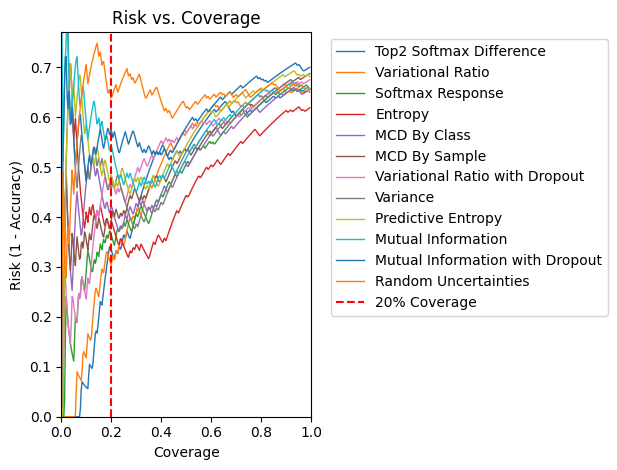

AK: 20 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Softmax Response                    	0.9500
Top2 Softmax Difference             	0.9500
Random Uncertainties                	0.9500
MCD By Sample                       	0.9500
MCD By Class                        	0.9500
Variance                            	0.9500
Variational Ratio                   	0.9500
Variational Ratio with Dropout      	0.9500
Entropy                             	0.9500
Predictive Entropy                  	0.9500
Mutual Information                  	0.9500
Mutual Information with Dropout     	0.9500

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Softmax Response                    	0.7498
Top2 Softmax Difference             	0.7498
Random Uncertainties                	0.7498
MCD By Sample                       	0.7498
MCD By Class                        	0.7498
Variance                           

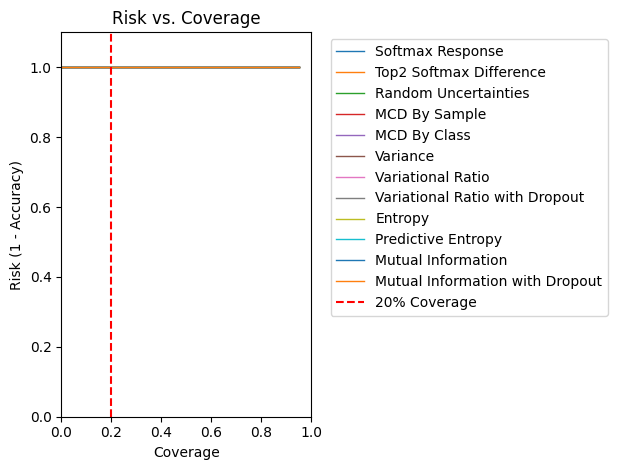


BCC: 20 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Random Uncertainties                	0.7483
Variational Ratio with Dropout      	0.8403
MCD By Class                        	0.8485
Top2 Softmax Difference             	0.8870
Variational Ratio                   	0.8870
Entropy                             	0.8871
Mutual Information with Dropout     	0.8910
Mutual Information                  	0.8945
Variance                            	0.9033
Softmax Response                    	0.9035
Predictive Entropy                  	0.9238
MCD By Sample                       	0.9404

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Random Uncertainties                	0.5531
Variational Ratio with Dropout      	0.6401
MCD By Class                        	0.6484
Top2 Softmax Difference             	0.6868
Variational Ratio                   	0.6868
Entropy                          

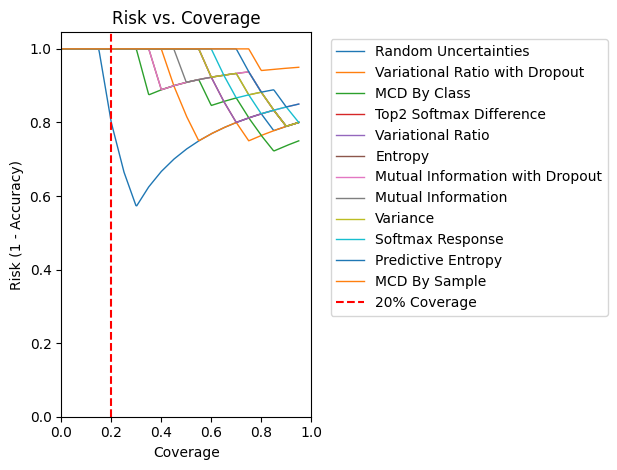


BKL: 20 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Variational Ratio with Dropout      	0.6500
Variational Ratio                   	0.6910
Top2 Softmax Difference             	0.7035
Random Uncertainties                	0.8021
Softmax Response                    	0.8244
MCD By Sample                       	0.8276
MCD By Class                        	0.8498
Predictive Entropy                  	0.8525
Mutual Information with Dropout     	0.8561
Variance                            	0.8803
Mutual Information                  	0.8837
Entropy                             	0.8936

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Top2 Softmax Difference             	0.5426
Variational Ratio                   	0.5426
Variational Ratio with Dropout      	0.5682
Softmax Response                    	0.6243
MCD By Sample                       	0.6275
Random Uncertainties             

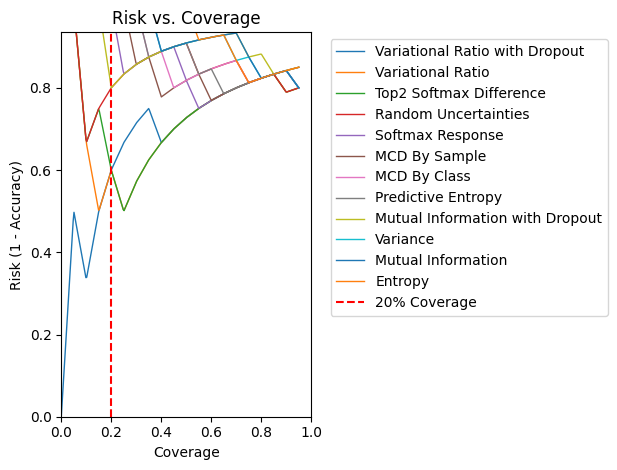


DF: 20 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Variational Ratio                   	0.4603
Top2 Softmax Difference             	0.4741
Variational Ratio with Dropout      	0.4967
MCD By Sample                       	0.6263
Random Uncertainties                	0.6374
Softmax Response                    	0.7089
Entropy                             	0.7475
Variance                            	0.8422
Mutual Information with Dropout     	0.8591
MCD By Class                        	0.8600
Mutual Information                  	0.8728
Predictive Entropy                  	0.8775

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Variational Ratio                   	0.3761
Top2 Softmax Difference             	0.3848
Variational Ratio with Dropout      	0.4074
MCD By Sample                       	0.4779
Random Uncertainties                	0.5214
Softmax Response                  

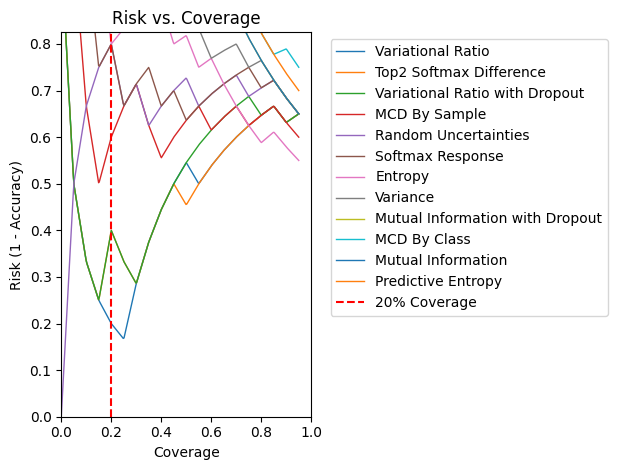


MEL: 20 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Top2 Softmax Difference             	0.0288
Variational Ratio                   	0.0288
Softmax Response                    	0.0404
Variance                            	0.0404
Mutual Information                  	0.0812
Random Uncertainties                	0.0862
MCD By Sample                       	0.1665
Entropy                             	0.1799
Predictive Entropy                  	0.1943
MCD By Class                        	0.2082
Variational Ratio with Dropout      	0.2830
Mutual Information with Dropout     	0.3648

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Top2 Softmax Difference             	0.0288
Variational Ratio                   	0.0288
Softmax Response                    	0.0404
Variance                            	0.0404
Mutual Information                  	0.0812
Random Uncertainties             

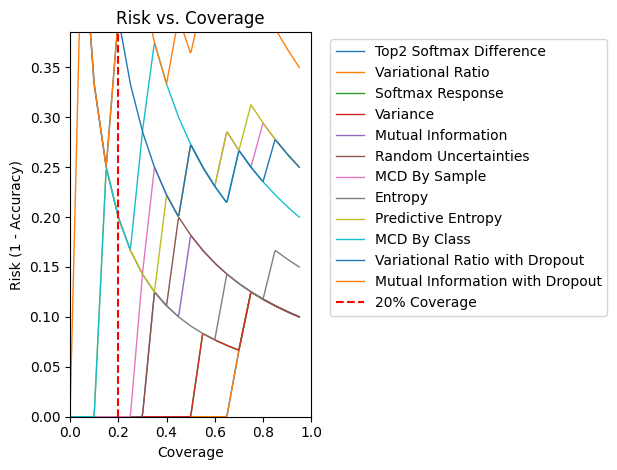


NV: 20 samples

AURC (full):
Label                          	AURC
----------------------------------------------
MCD By Class                        	0.5239
Entropy                             	0.6578
Variational Ratio with Dropout      	0.6805
Mutual Information with Dropout     	0.6833
Random Uncertainties                	0.7245
MCD By Sample                       	0.7316
Predictive Entropy                  	0.7955
Mutual Information                  	0.8904
Variance                            	0.8991
Variational Ratio                   	0.8996
Softmax Response                    	0.9029
Top2 Softmax Difference             	0.9065

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
MCD By Class                        	0.4305
Entropy                             	0.4752
Mutual Information with Dropout     	0.5007
Variational Ratio with Dropout      	0.5395
Random Uncertainties                	0.5585
MCD By Sample                     

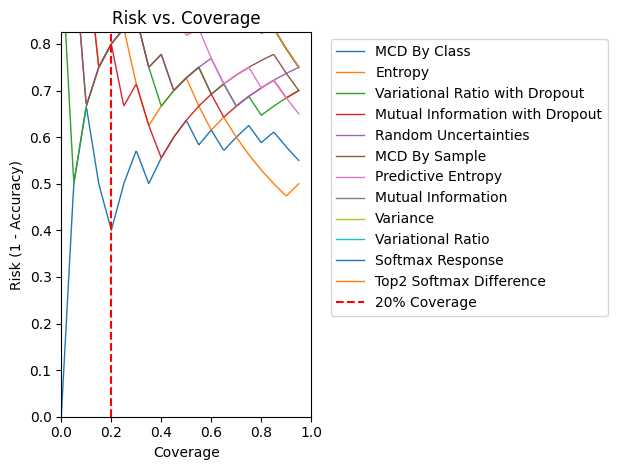


SCC: 20 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Softmax Response                    	0.9500
Top2 Softmax Difference             	0.9500
Random Uncertainties                	0.9500
MCD By Sample                       	0.9500
MCD By Class                        	0.9500
Variance                            	0.9500
Variational Ratio                   	0.9500
Variational Ratio with Dropout      	0.9500
Entropy                             	0.9500
Predictive Entropy                  	0.9500
Mutual Information                  	0.9500
Mutual Information with Dropout     	0.9500

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Softmax Response                    	0.7498
Top2 Softmax Difference             	0.7498
Random Uncertainties                	0.7498
MCD By Sample                       	0.7498
MCD By Class                        	0.7498
Variance                         

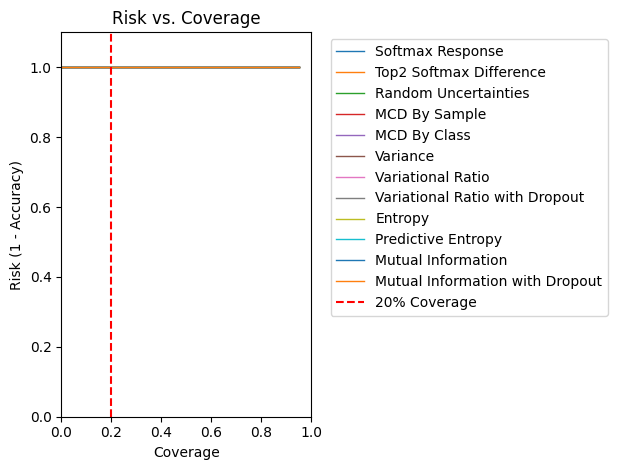


VASC: 20 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Variational Ratio                   	0.0175
Top2 Softmax Difference             	0.0206
Softmax Response                    	0.0275
Variational Ratio with Dropout      	0.0401
MCD By Sample                       	0.0868
Variance                            	0.0944
Random Uncertainties                	0.1642
Predictive Entropy                  	0.2074
Entropy                             	0.2098
MCD By Class                        	0.2240
Mutual Information with Dropout     	0.2906
Mutual Information                  	0.2950

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
Variational Ratio                   	0.0175
Top2 Softmax Difference             	0.0206
Softmax Response                    	0.0275
Variational Ratio with Dropout      	0.0401
MCD By Sample                       	0.0868
Variance                        

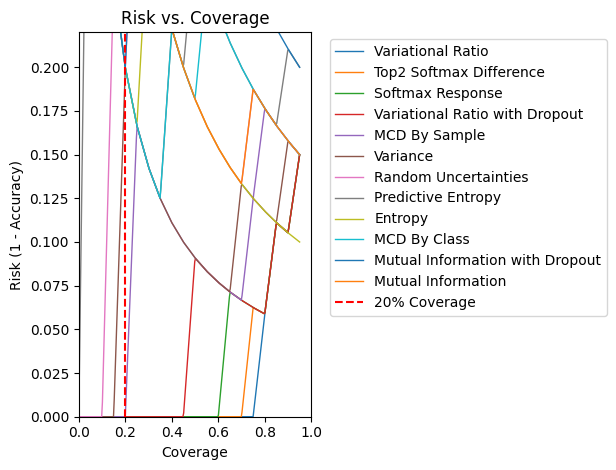


done


In [26]:
# Define the desired metrics to plot
# comment out undesired metrics
desired_metrics = [
    "Softmax Response",
    "Top2 Softmax Difference",
    "Random Uncertainties",
    "MCD By Sample",
    "MCD By Class",
    "Variance",
    "Variational Ratio",
    "Variational Ratio with Dropout",
    "Entropy",
    "Predictive Entropy",
    "Mutual Information",
    "Mutual Information with Dropout"
]

# Select desired metrics for all samples
selected_labels_list, selected_risks_list = select_desired_metrics(labels_list, risks_list, desired_metrics)

# Print information about all classes
print(f"All Classes: {len(selected_risks_list[0])} samples")
x_smooth_percentage_interp, x_smooth_percentage = smooth_calcs(selected_risks_list[0])
calculate_aurc(selected_risks_list, selected_labels_list, x_smooth_percentage_interp, x_smooth_percentage)
plot_risk_coverage(selected_risks_list, selected_labels_list, x_smooth_percentage_interp, x_smooth_percentage)

# Iterate over each class
for i in range(len(class_names)):
    # Select desired metrics for the current class
    selected_labels_list_class, selected_risks_list_class = select_desired_metrics(labels_list_by_class[i], risks_list_by_class[i], desired_metrics)
    
    # Print information about the current class
    print(f"{class_names[i]}: {len(selected_risks_list_class[0])} samples")
    x_smooth_percentage_interp, x_smooth_percentage = smooth_calcs(selected_risks_list_class[0])
    calculate_aurc(selected_risks_list_class, selected_labels_list_class, x_smooth_percentage_interp, x_smooth_percentage)
    plot_risk_coverage(selected_risks_list_class, selected_labels_list_class, x_smooth_percentage_interp, x_smooth_percentage)
    print()

print("done")